In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt
from typing import Optional, Any, cast

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.architectures.sequential import Sequential
from src.models import TrainingArguments, LabeledData
from src.architectures.auto_encoder import VAE, VAELoss
from src import Tensor, activations, optimizers, callbacks
from src.core.utils import data_analysis, data_processing, context_manager
from src.architectures.auto_encoder.config import VAEConfig, VAEEncoderConfig, VAEDecoderConfig, DenseConfig, Conv2DConfig, ConvTranspose2DConfig

### Constants and hyperparameters

In [ ]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'variational_autoencoder')

In [3]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split_pct = 0.2 # Percentage of samples to use for validation
learning_rate = 5e-04 # Learning rate for the optimizer
batch_size = 512 # Number of samples to use for each batch
epochs = 100 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))    

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels), dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels), dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data(data=(X_train, y_train), split_pct=train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split_pct, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (38400, 28, 28, 1) (38400,)
Validation set: (9600, 28, 28, 1) (9600,)
Testing set: (12000, 28, 28, 1) (12000,)


### Data processing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Add noise to the input data
def add_noise(X: np.ndarray, noise: float) -> np.ndarray:
    """
    Add noise to the input data.
    
    Parameters:
    - X (np.ndarray): The input data to add noise to
    - noise (float): The noise to add to the input data

    Returns:
    - np.ndarray: The input data with noise added
    """
    
    # Add noise to the input data
    X_noisy = X + noise * np.random.normal(loc=0, scale=1.0, size=X.shape)
    
    # Clip the values to be between 0 and 1
    X_noisy = np.clip(X_noisy, 0., 1.)
    
    # Return the noisy input data
    return X_noisy


# Add noise to the input data
noise_factor = 0.6
X_train_noisy = Tensor(add_noise(X_train.data, noise_factor))
X_valid_noisy = Tensor(add_noise(X_valid.data, noise_factor))
X_test_noisy = Tensor(add_noise(X_test.data, noise_factor))

### Data visualization

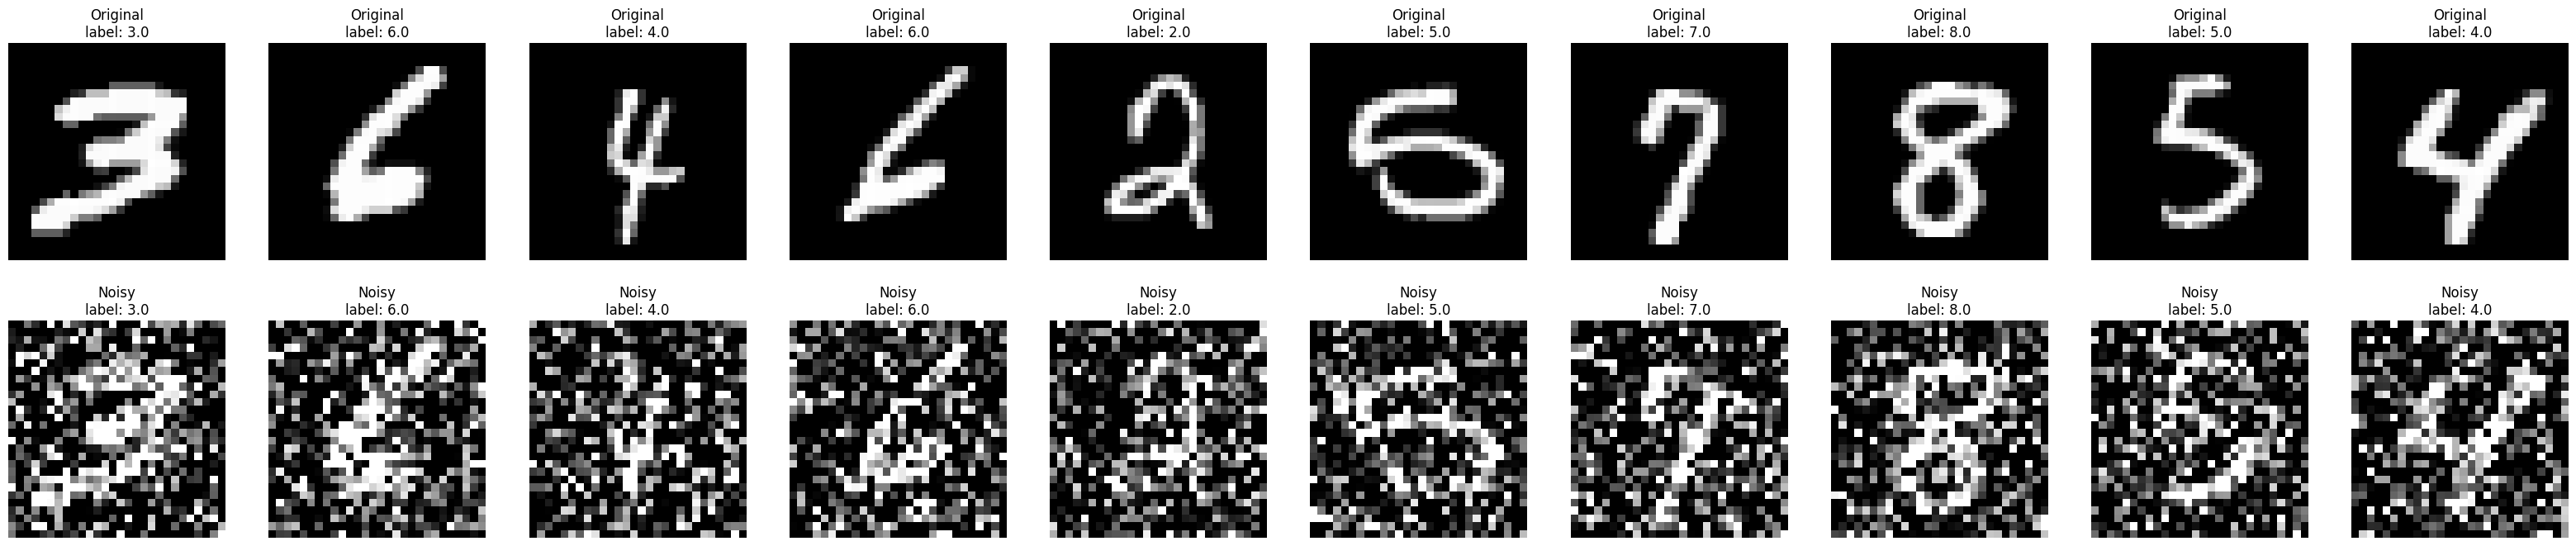

In [8]:
def plot_samples(originale_samples: list[np.ndarray], noisy_samples: Optional[list[np.ndarray]] = None, reconstructed_samples: Optional[list[np.ndarray]] = None, labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - originale_samples (list[np.ndarray]): The original samples
    - noisy_samples (list[np.ndarray]): The noisy samples
    - reconstructed_samples (list[np.ndarray]): The reconstructed samples
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Build a list of image types to plot along with their titles.
    plot_info = [('Original', originale_samples)]
    if noisy_samples is not None:
        plot_info.append(('Noisy', noisy_samples))
    if reconstructed_samples is not None:
        plot_info.append(('Reconstructed', reconstructed_samples))
        
    # Get the number of rows and samples.
    n_rows = len(plot_info)
    n_samples = len(originale_samples)
    
    # Create a grid: columns = samples, rows = image types.
    _, axes = plt.subplots(n_rows, n_samples, figsize=(n_samples * 4, n_rows * 4))
    
    # Ensure axes is a 2D array.
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0) 
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)
    
    def add_image(ax: Any, image: np.ndarray, title: str) -> None:
        """
        Add an image to a subplot.
        
        Parameters:
        - ax (Any): The subplot to add the image to
        - image (np.ndarray): The image to add to the subplot
        - title (str): The title of the subplot
        """
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(title)
    
    # Loop over rows (image types) and columns (samples).
    for i, (title_prefix, samples) in enumerate(plot_info):
        for j in range(n_samples):
            # Append the label text if provided.
            add_image(axes[i, j], samples[j], f"{title_prefix}\nlabel: {labels[j]}" if labels is not None else title_prefix)
        
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    labels = list(y_test.data[:10])
)

In [9]:
# Define the dimension of the latent space
latent_dim = 32

# Initialize the Variational Autoencoder model
vae = Sequential(
    name = "Variational Autoencoder",
    modules = [
        VAE(
            vae_config = VAEConfig(
                encoder = VAEEncoderConfig(
                    conv_1 = Conv2DConfig(
                        num_filters = 32, 
                        kernel_size = (3, 3), 
                        stride = (2, 2), 
                        padding = "same",
                        activation = activations.ReLU()
                    ),
                    conv_2 = Conv2DConfig(
                        num_filters = 64, 
                        kernel_size = (3, 3), 
                        stride = (2, 2), 
                        padding = "same",
                        activation = activations.ReLU()
                    ),
                    fc = DenseConfig(
                        num_units = latent_dim, 
                        activation = activations.ReLU()
                    )
                ),
                latent_dim = latent_dim,
                decoder = VAEDecoderConfig(
                    fc = DenseConfig(
                        num_units = 7*7*64, 
                        activation = activations.ReLU()
                    ),
                    deconv_1 = ConvTranspose2DConfig(
                        num_filters = 64, 
                        kernel_size = (3, 3), 
                        stride = (2, 2), 
                        padding = (1, 1), 
                        output_padding = (1, 1),
                        activation = activations.ReLU()
                    ),
                    deconv_2 = ConvTranspose2DConfig(
                        num_filters = 32, 
                        kernel_size = (3, 3), 
                        stride = (2, 2), 
                        padding = (1, 1), 
                        output_padding = (1, 1),
                        activation = activations.ReLU()
                    ),
                    deconv_3 = ConvTranspose2DConfig(
                        num_filters = 1, 
                        kernel_size = (3, 3), 
                        stride = (1, 1), 
                        padding = (1, 1), 
                        activation = activations.Sigmoid()
                    )
                )
            )
        )
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function with KL annealing
# beta=1.0 is the final value, annealing_epochs=30 means beta will linearly increase from 0 to 1.0 over 30 epochs
# This allows the model to first learn reconstruction, then gradually regularize the latent space
loss_fn = VAELoss(beta=1.0, annealing_epochs=30)

### Initializing the model

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    vae.eval()
    
    # Call the model with a batch of data to initialize it
    vae(x=X_train[:batch_size])

In [11]:
# Display the encoder summary
vae.modules[0].encoder.summary()

# Display the decoder summary
vae.modules[0].decoder.summary()

# Display the model summary
vae.summary()


vae.encoder

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
encoder.conv1 (Conv2D)                                 (512, 14, 14, 32)   320                 
-----------------------------------------------------------------------------------------------
encoder.conv2 (Conv2D)                                 (512, 7, 7, 64)     18496               
-----------------------------------------------------------------------------------------------
encoder.flatten (Flatten)                              (512, 3136)         0                   
-----------------------------------------------------------------------------------------------
encoder.fc (Dense)                                     (512, 32)           100384              
-----------------------------------------------------------------------------------------------
encoder.fc_mu (Dense)     

### Training the model

In [12]:
# Define the training arguments
train_arguments = TrainingArguments(
    train_data = LabeledData(input={'x': X_train_noisy}, target=X_train),
    valid_data = LabeledData(input={'x': X_valid_noisy}, target=X_valid),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Train the model
history = vae.fit(train_arguments)

Epoch 1/100 --> loss: 0.38206 | val_loss: 0.27206                                                                                                    
Epoch 2/100 --> loss: 0.26694 | val_loss: 0.26417                                                                                                    
Epoch 3/100 --> loss: 0.25907 | val_loss: 0.25431                                                                                                    
Epoch 4/100 --> loss: 0.24861 | val_loss: 0.24643                                                                                                    
Epoch 5/100 --> loss: 0.2356 | val_loss: 0.22609                                                                                                     
Epoch 6/100 --> loss: 0.21813 | val_loss: 0.21242                                                                                                    
Epoch 7/100 --> loss: 0.20713 | val_loss: 0.2015                                                    

In [13]:
# Save the model
vae.save(model_path)

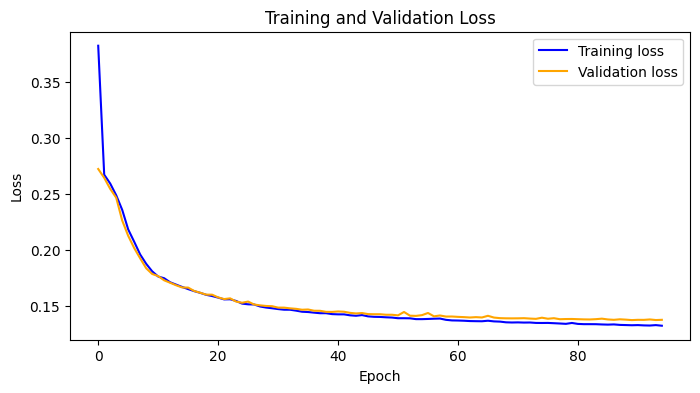

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Inference

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    vae.eval()

    # Denoise the test set
    X_test_out = vae(
        x = X_test_noisy,
        batch_size = batch_size
    )

    # Cast the output to the correct type and unpack the denoised test set
    X_test_out = cast(tuple[Tensor, Tensor, Tensor], X_test_out)
    X_test_denoised, _, _ = X_test_out

# Reshape the denoised test set
X_test_denoised = X_test_denoised.reshape((-1, *X_test.shape[1:]))

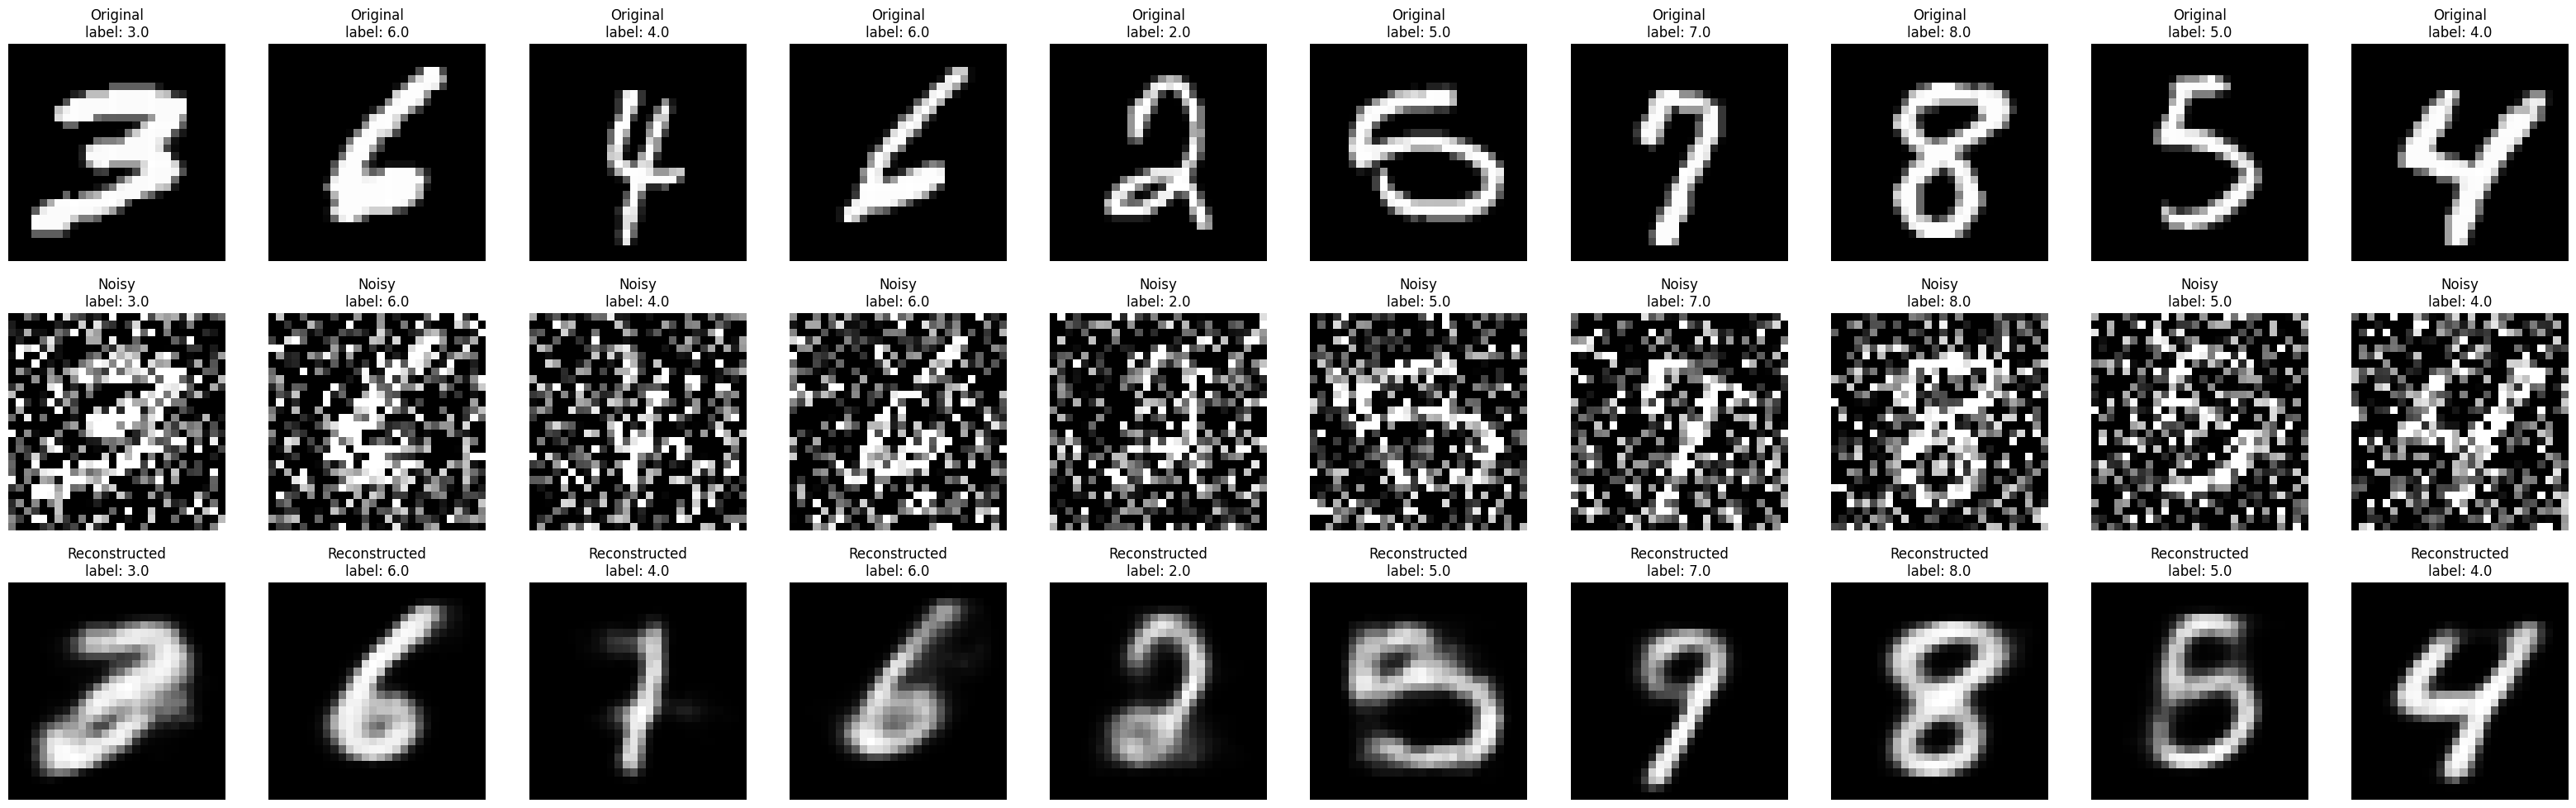

In [16]:
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    reconstructed_samples = list(X_test_denoised.data[:10]),
    labels = list(y_test.data[:10])
)

### Generation

In [17]:
# Generate n random images (noise)
n_images = 10
random_images = np.random.rand(n_images, *X_train.shape[1:])
random_images = add_noise(random_images, noise_factor)

# Convert the random images to a tensor
random_images = Tensor(random_images)

In [18]:
# Define the number of denoise steps
denoise_steps = 10

# Create a list to store the denoised images
denoised_images = [random_images.reshape((-1, *X_train.shape[1:]))]

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    vae.eval()
    
    # Iterate over the denoise steps
    for i in range(denoise_steps):
        # Denoise the random images using the autoencoder
        random_images = vae(random_images)
        random_images = cast(tuple[Tensor, Tensor, Tensor], random_images)[0]

        # Add the denoised images to the list
        denoised_images.append(random_images.reshape((-1, *X_train.shape[1:])))

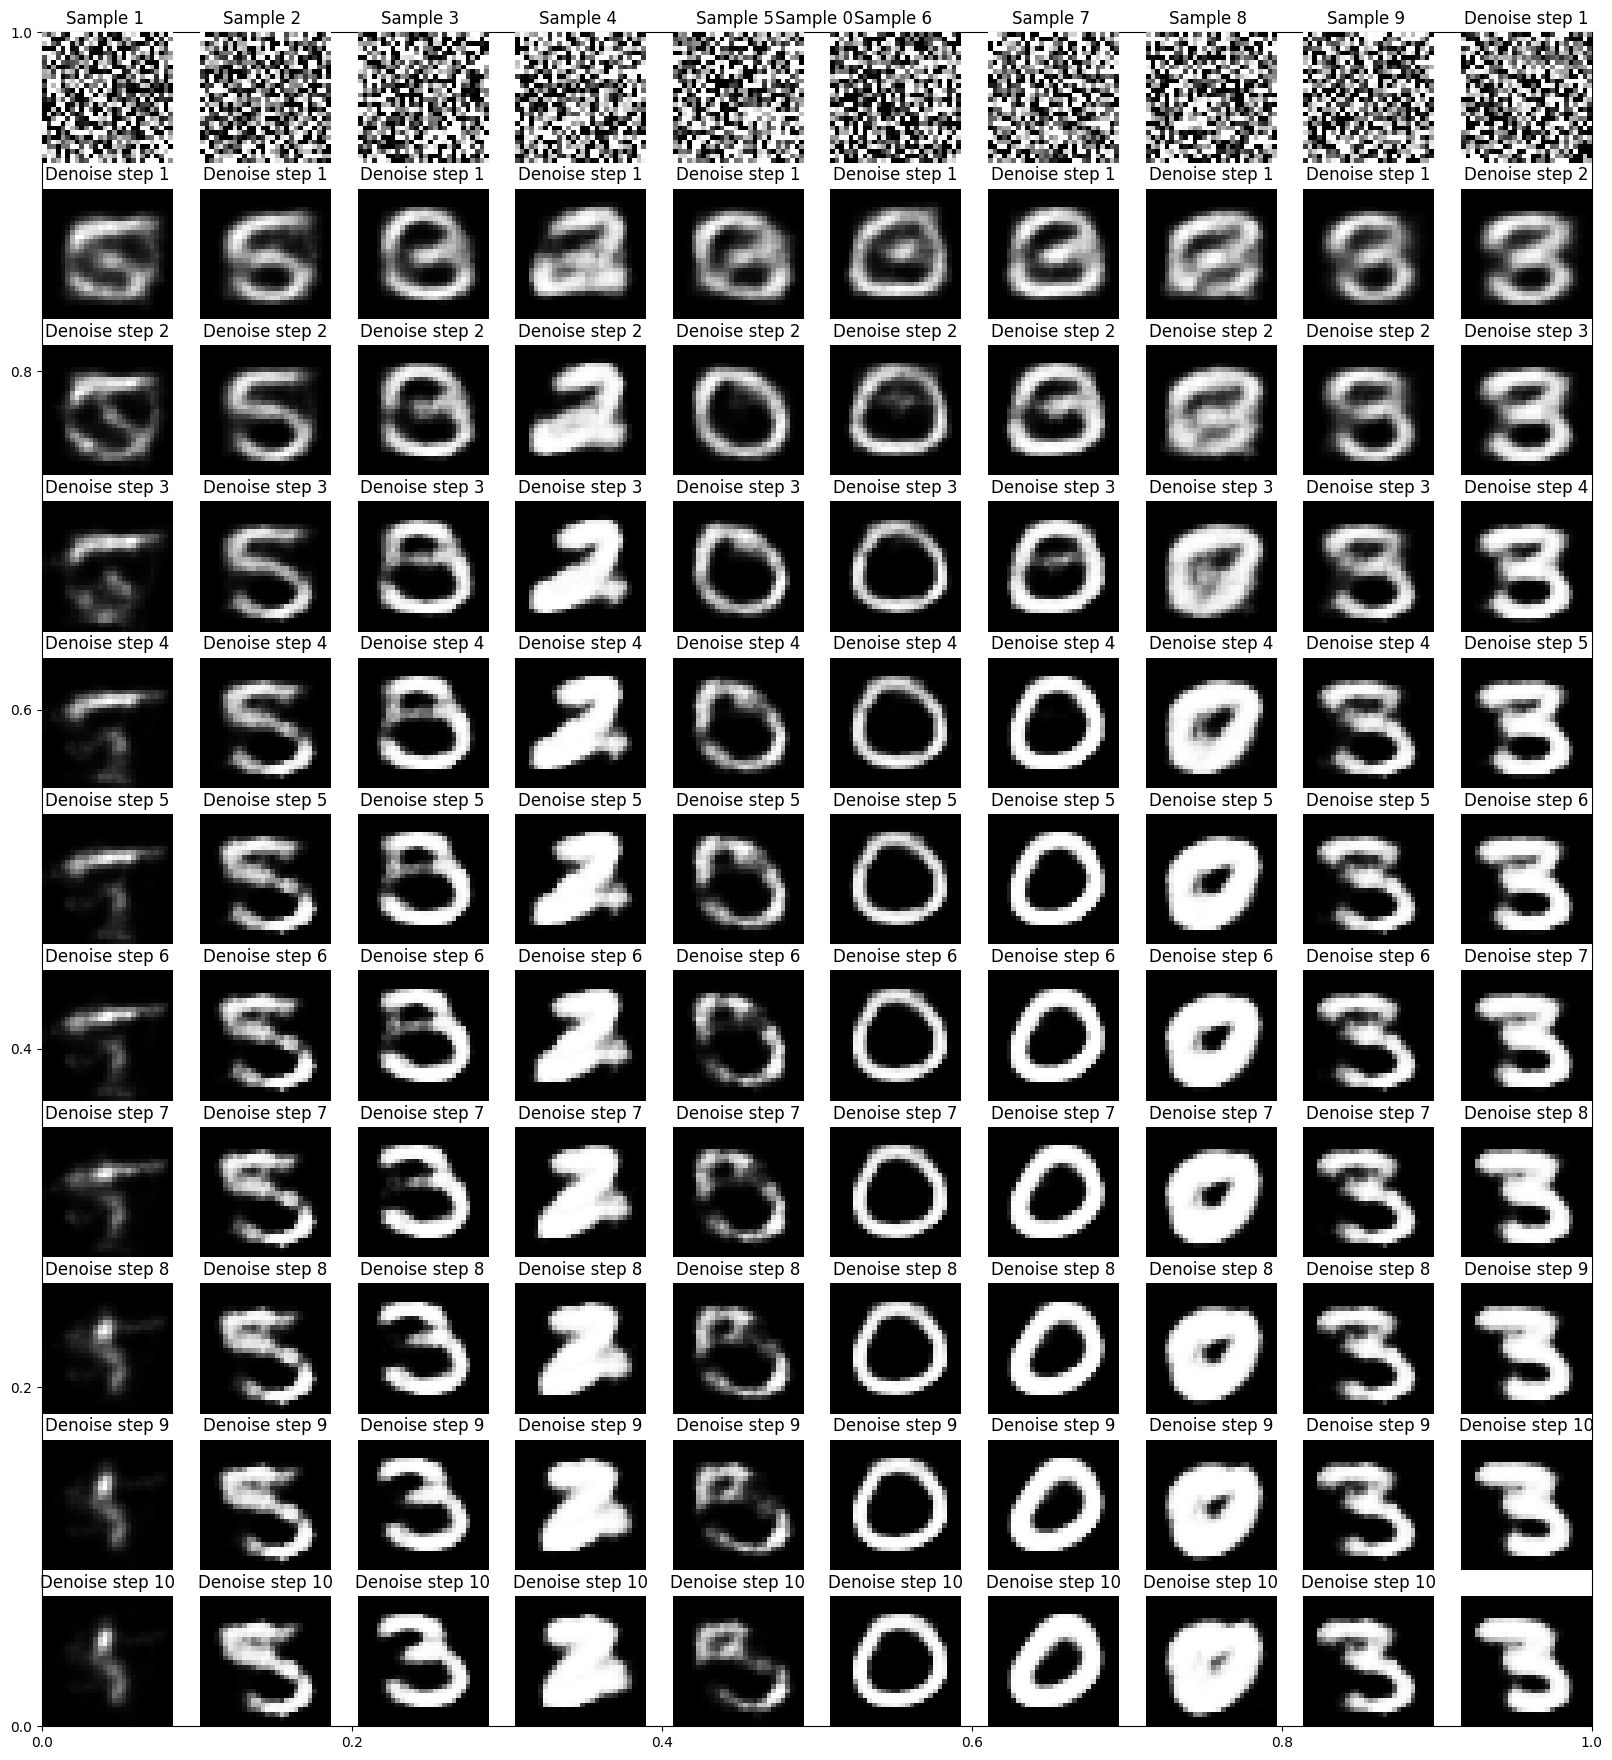

In [19]:
# Plot the denoised images
plt.figure(figsize=(2*n_images, 2*len(denoised_images)))
for i, images in enumerate(denoised_images):
    for j, image in enumerate(images.data):
        plt.title(f'Sample {j} ' if i == 0 else f'Denoise step {i}')
        plt.subplot(len(denoised_images), n_images, i * n_images + j + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')